# Introduction

The pachter lab wants to see my analysis fail on Google Colab so they can more easily look at it.

In [ ]:
import numpy
import pandas
import sys
from pathlib import Path
import requests
from subprocess import check_call, run
from matplotlib import pyplot, cm

In [ ]:
kallisto_git = Path('kallisto')
if not kallisto_git.exists():
  !apt update
  !apt install -y cmake
  !apt-get install autoconf
  !git clone https://github.com/pachterlab/kallisto.git
kallisto_build = kallisto_git / 'build'
if not kallisto_build.exists():
  kallisto.build.mkdir()
!pushd kallisto/build && cmake .. && make && popd
!chmod +x kallisto/build/src/kallisto

/content/kallisto/build /content
shared build
-- Configuring done
-- Generating done
-- Build files have been written to: /content/kallisto/build
[ 27%] Built target htslib
[ 93%] Built target kallisto_core
[100%] Built target kallisto
/content


In [ ]:
def DownloadFile(url, local_filename):
    r = requests.get(url)
    f = open(local_filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return 

In [ ]:
def sc_scatter(kallisto, rsem, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in kallisto.index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(kallisto+0.01, rsem+0.01, color=colors, s=2)
    count = numpy.sum((kallisto > 0) & (rsem > 0))
    ax.set_title(f'id {cell_id}\nCount: {count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('kallisto')
    ax.set_ylabel('rsem')
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [ ]:
genome_root = Path('genome')
if not genome_root.exists():
  genome_root.mkdir()
genome_mm10_minimal = genome_root / 'mm10-M21_minimal-male'
if not genome_mm10_minimal.exists():
  genome_mm10_minimal.mkdir()

index_mm10_minimal = genome_mm10_minimal / 'mm10-M21_minimal-male-kallisto-0.46.2.idx'
if not index_mm10_minimal.exists():
  DownloadFile(
      'http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21_minimal-male/mm10-M21_minimal-male-kallisto-0.46.2.idx', 
      index_mm10_minimal)
  
gtf_mm10_minimal = genome_mm10_minimal / 'mm10-M21_minimal_det-male.gtf'
if not gtf_mm10_minimal.exists():
  DownloadFile(
      'http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21_minimal-male/mm10-M21_minimal_det-male.gtf', 
      gtf_mm10_minimal)

In [ ]:
genome_root = Path('genome')
if not genome_root.exists():
  genome_root.mkdir()
genome_mm10_encode = genome_root / 'mm10-M21-male'
if not genome_mm10_encode.exists():
  genome_mm10_encode.mkdir()

index_mm10_encode = genome_mm10_encode / 'mm10-M21-male-kallisto-0.46.2.idx'
if not index_mm10_encode.exists():
  DownloadFile(
      'http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21-male/mm10-M21-male-kallisto-0.46.2.idx', 
      index_mm10_encode)
  
gtf_mm10_encode = genome_mm10_encode / 'gencode.vM21-tRNAs-exon-ERCC.gff'
if not gtf_mm10_minimal.exists():
  DownloadFile(
      'http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21-male/gencode.vM21-tRNAs-exon-ERCC.gff', 
      gtf_mm10_encode)

The 920 cells we used in our paper can be found here with the fastqs linked into the directory tree. Later analysis just pulled the fastqs from wherever they still were on our filesystem and I didn't include them in the analysis directories.

In [ ]:
fastq_root = 'https://woldlab.caltech.edu/~diane/C1_mouse_limb_timecourse/'
fastqs = [
        '18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L001_R1_001.fastq.gz',
        '18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L002_R1_001.fastq.gz',
        '18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L001_R1_001.fastq.gz',
        '18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L002_R1_001.fastq.gz',
        '19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz',
        '19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz',

]

for filename in fastqs:
  path = Path(filename)
  if not path.parent.exists():
    path.parent.mkdir()
  if not path.exists():
    print('Downloading {}'.format(path))
    DownloadFile(fastq_root + filename, path)

In [ ]:
fastqs_by_library = {}
for filename in fastqs:
  path = Path(filename)
  fastqs_by_library.setdefault(str(path.parent), []).append(filename)

In [ ]:
fastqs_by_library

{'18089_H4': ['18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L001_R1_001.fastq.gz',
  '18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L002_R1_001.fastq.gz'],
 '18273_D5': ['18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L001_R1_001.fastq.gz',
  '18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L002_R1_001.fastq.gz'],
 '19908_C1': ['19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz',
  '19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz']}

In [ ]:
!kallisto version

kallisto, version 0.46.2


In [ ]:
# this would be better, but python is too old to capture stdout
def run_kallisto_bam(fastqs, library_id, length, sd, index_file):
  kallisto_out = Path(library_id)
  cmd = ["kallisto", "quant",
        "-i", str(index_mm10_minimal),
        "-o", library_id,
        "--genomebam",
        "--gtf", index_file,
        "--single",
        "--fragment-length={}".format(length),
        "--sd={}".format(sd),]
  cmd.extend(fastqs[library_id])
  return run(cmd, capture_output=True)

In [ ]:
#run_19908_c1 = run_kallisto_bam(fastqs_by_library, '19908_C1', 1759.25, 1103.91775, index_mm10_minimal)

In [ ]:
!kallisto quant -i genome/mm10-M21_minimal-male/mm10-M21_minimal-male-kallisto-0.46.2.idx \
   -o 19908_C1/minimal --genomebam --gtf genome/mm10-M21_minimal-male/mm10-M21_minimal_det-male.gtf \
   --single --fragment-length=1759.25 --sd=1103.91775 \
   19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz


[quant] fragment length distribution is truncated gaussian with mean = 1759.25, sd = 1103.92
[index] k-mer length: 31
[index] number of targets: 115,440
[index] number of k-mers: 105,021,148
tcmalloc: large alloc 3221225472 bytes == 0x55db0dc66000 @  0x7f130ef4c887 0x55db0be29ad2 0x55db0be22061 0x55db0bdf704a 0x7f130ddccbf7 0x55db0bdfb0da
[index] number of equivalence classes: 391,234
[quant] running in single-end mode
[quant] will process file 1: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz
[quant] will process file 2: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,659,329 reads, 486,608 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 833 rounds
[  bam] writing pseudoalignments to BAM format .. 

In [ ]:
!dmesg | tail

[   17.067234] br0: port 1(veth6d73706) entered blocking state
[   17.072966] br0: port 1(veth6d73706) entered forwarding state
[ 5196.539875] kallisto[37347]: segfault at 0 ip 0000563680ef8d05 sp 00007fe1b57aca40 error 4 in kallisto[563680e6f000+118000]
[ 5196.551191] Code: 80 fc ff ff 48 01 d6 48 89 85 70 fc ff ff 8b 44 02 08 44 8b 46 08 89 85 98 fc ff ff 48 8b 81 c0 00 00 00 44 89 85 78 fc ff ff <83> 38 01 75 37 48 8b 9d 70 fc ff ff 48 8b 85 80 fc ff ff 48 8d 34
[ 5699.545963] kallisto[41183]: segfault at 0 ip 0000561702330d05 sp 00007f295f957a40 error 4 in kallisto[5617022a7000+118000]
[ 5699.557368] Code: 80 fc ff ff 48 01 d6 48 89 85 70 fc ff ff 8b 44 02 08 44 8b 46 08 89 85 98 fc ff ff 48 8b 81 c0 00 00 00 44 89 85 78 fc ff ff <83> 38 01 75 37 48 8b 9d 70 fc ff ff 48 8b 85 80 fc ff ff 48 8d 34
[ 7629.102516] kallisto[53786]: segfault at 0 ip 00005645402bfd05 sp 00007f38c5721a40 error 4 in kallisto[564540236000+118000]
[ 7629.113948] Code: 80 fc ff ff 48 01 d6 48 89 85 70 fc ff f

In [ ]:
ls  19908_C1/minimal

abundance.tsv  tmp.12.bam  tmp.18.bam  tmp.23.bam  tmp.29.bam  tmp.5.bam
pseudoaln.bin  tmp.13.bam  tmp.19.bam  tmp.24.bam  tmp.2.bam   tmp.6.bam
run_info.json  tmp.14.bam  tmp.1.bam   tmp.25.bam  tmp.30.bam  tmp.7.bam
tmp.0.bam      tmp.15.bam  tmp.20.bam  tmp.26.bam  tmp.31.bam  tmp.8.bam
tmp.10.bam     tmp.16.bam  tmp.21.bam  tmp.27.bam  tmp.3.bam   tmp.9.bam
tmp.11.bam     tmp.17.bam  tmp.22.bam  tmp.28.bam  tmp.4.bam


The crash isn't reported by the notebook, but kallisto did crash.

Run it again, without trying to make the genomebam

In [ ]:
 # --genomebam --gtf genome/mm10-M21_minimal-male/mm10-M21_minimal_det-male.gtf \
!kallisto quant -i genome/mm10-M21_minimal-male/mm10-M21_minimal-male-kallisto-0.46.2.idx \
   -o 19908_C1/minimal \
   --single --fragment-length=1759.25 --sd=1103.91775 \
   19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz


[quant] fragment length distribution is truncated gaussian with mean = 1759.25, sd = 1103.92
[index] k-mer length: 31
[index] number of targets: 115,440
[index] number of k-mers: 105,021,148
tcmalloc: large alloc 3221225472 bytes == 0x560955584000 @  0x7fa1456f6887 0x56095393cad2 0x560953935061 0x56095390a04a 0x7fa144576bf7 0x56095390e0da
[index] number of equivalence classes: 391,234
[quant] running in single-end mode
[quant] will process file 1: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz
[quant] will process file 2: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,659,329 reads, 486,608 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 833 rounds



In [ ]:
# --genomebam --gtf genome/mm10-M21-male/gencode.vM21-tRNAs-exon-ERCC.gff \
!kallisto quant -i genome/mm10-M21-male/mm10-M21-male-kallisto-0.46.2.idx \
   -o 19908_C1/encode \
   --single --fragment-length=1759.25 --sd=1103.91775 \
   19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz


[quant] fragment length distribution is truncated gaussian with mean = 1759.25, sd = 1103.92
[index] k-mer length: 31
[index] number of targets: 168,207
[index] number of k-mers: 120,997,101
tcmalloc: large alloc 3221225472 bytes == 0x560e9b564000 @  0x7efd7c103887 0x560e99711ad2 0x560e9970a061 0x560e996df04a 0x7efd7af83bf7 0x560e996e30da
[index] number of equivalence classes: 555,826
[quant] running in single-end mode
[quant] will process file 1: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz
[quant] will process file 2: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,659,329 reads, 489,547 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 833 rounds



Compare a filtered annotation set that contains the same annotations as in the 10x gtf file (mostly protein coding, antisense, and lincRNA) plus ERCC spikes. See <a href="https://nbviewer.jupyter.org/url/woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/make-mm10-minimal-gtf.ipynb">make-mm10-minimal-gtf.ipynb</a>. Kallisto index and source files are in <a href="http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21_minimal-male/">~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21_minimal-male</a>

In [ ]:
kallisto_minimal_transcript_count = pandas.read_csv('19908_C1/minimal/abundance.tsv', sep='\t').set_index('target_id')['est_counts']
kallisto_minimal_transcript_count.shape

(115440,)

In [ ]:
rsem_minimal_transcript = pandas.read_csv('http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/c1_pseudo/rsem_minimal/19908_C1/19908_C1-mm10-M21_minimal-male_anno_rsem.isoforms.results', sep='\t')
rsem_minimal_transcript_count = rsem_minimal_transcript.set_index('transcript_id')['expected_count']
rsem_minimal_transcript_count.shape


(115440,)

Red dots are the ERCC spikes

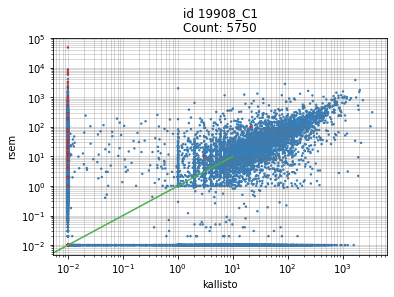

In [ ]:
sc_scatter(kallisto_minimal_transcript_count, rsem_minimal_transcript_count, '19908_C1')

Compare kallisto counts to rsem counts using the full encode annotation that contains tRNAs, everything in GENCODE, and spikeins.

Genome directory with fa and gtf files are in <a href="http://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21-male/">~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21-male/</a>

In [ ]:
kallisto_encode_transcript_count = pandas.read_csv('19908_C1/encode/abundance.tsv', sep='\t').set_index('target_id')['est_counts']
kallisto_encode_transcript_count.shape

(168207,)

In [ ]:
rsem_encode_transcript = pandas.read_csv('http://woldlab.caltech.edu/~diane/C1_mouse_limb_combined/all_analysis_M21/19908_C1/19908_C1-mm10-M21-male_anno_rsem.isoforms.results', sep='\t')
rsem_encode_transcript_count = rsem_encode_transcript.set_index('transcript_id')['expected_count']
rsem_encode_transcript_count.shape

(168207,)

Red dots are the ERCC spikes

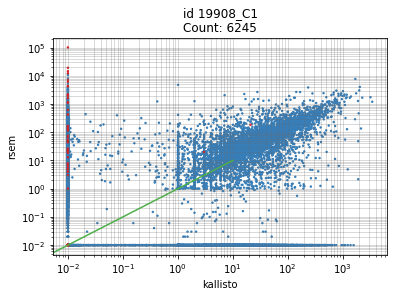

In [ ]:
sc_scatter(kallisto_encode_transcript_count, rsem_encode_transcript_count, '19908_C1')